In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import pickle

In [6]:
data = pd.read_csv('C:\\Users\\aniru\\Downloads\\Spam Classification\\spam.csv', encoding='ISO-8859-1', encoding_errors='strict')


In [7]:
data.shape

(5572, 5)

ANALYZING THE DATA

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [9]:
data.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [10]:
data['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

PERFORMING EDA

In [11]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [12]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
encoder = LabelEncoder()
data['v1'] = encoder.fit_transform(data['v1'])

In [14]:
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
data.duplicated().sum()

403

In [16]:
data = data.drop_duplicates(keep='first')

In [17]:
data.duplicated().sum()

0

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aniru\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [19]:
data['words'] = data['v2'].apply(lambda x:len(nltk.word_tokenize(x)))

In [20]:
data.head()

,v1,v2,words
0,0,"Go until jurong point, crazy.. Available only ...",24
1,0,Ok lar... Joking wif u oni...,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,37
3,0,U dun say so early hor... U c already then say...,13
4,0,"Nah I don't think he goes to usf, he lives aro...",15


In [21]:
data[data['v1']==0][['words']].describe()

,words
count,4516.000000
mean,17.123782
std,13.493970
min,1.000000
25%,8.000000
50%,13.000000
75%,22.000000
max,220.000000


In [22]:
data[data['v1']==1][['words']].describe()

,words
count,653.000000
mean,27.667688
std,7.008418
min,2.000000
25%,25.000000
50%,29.000000
75%,32.000000
max,46.000000


<Axes: xlabel='words', ylabel='Count'>

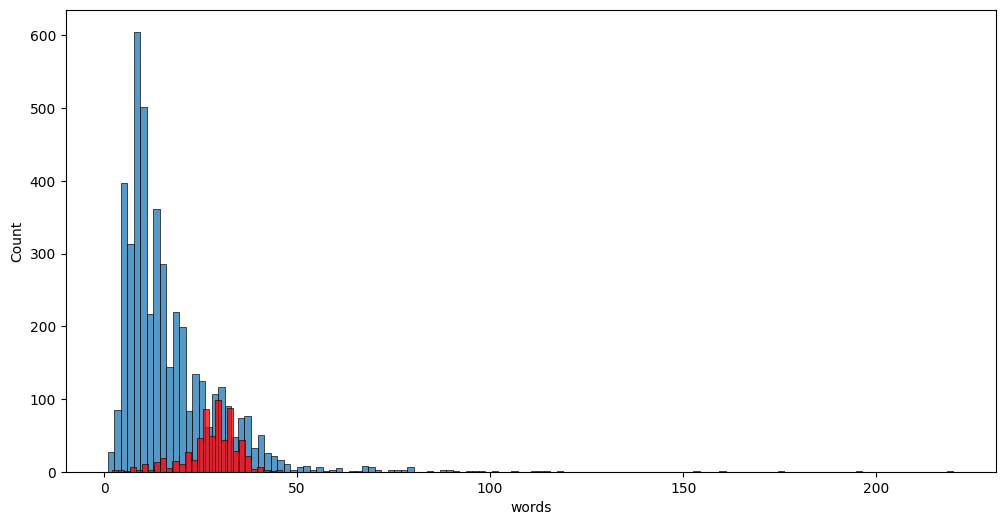

In [23]:
plt.figure(figsize=(12,6))
sns.histplot(data[data['v1'] == 0]['words'])
sns.histplot(data[data['v1'] == 1]['words'],color='red')

DATA PREPARATION/ TRANSFORMATION

In [24]:
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))


    return " ".join(y)

In [25]:
data['after_transformation'] = data['v2'].apply(transform_text)

In [26]:
data.head()

,v1,v2,words,after_transformation
0,0,"Go until jurong point, crazy.. Available only ...",24,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,8,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,37,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,13,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",15,nah think goe usf live around though


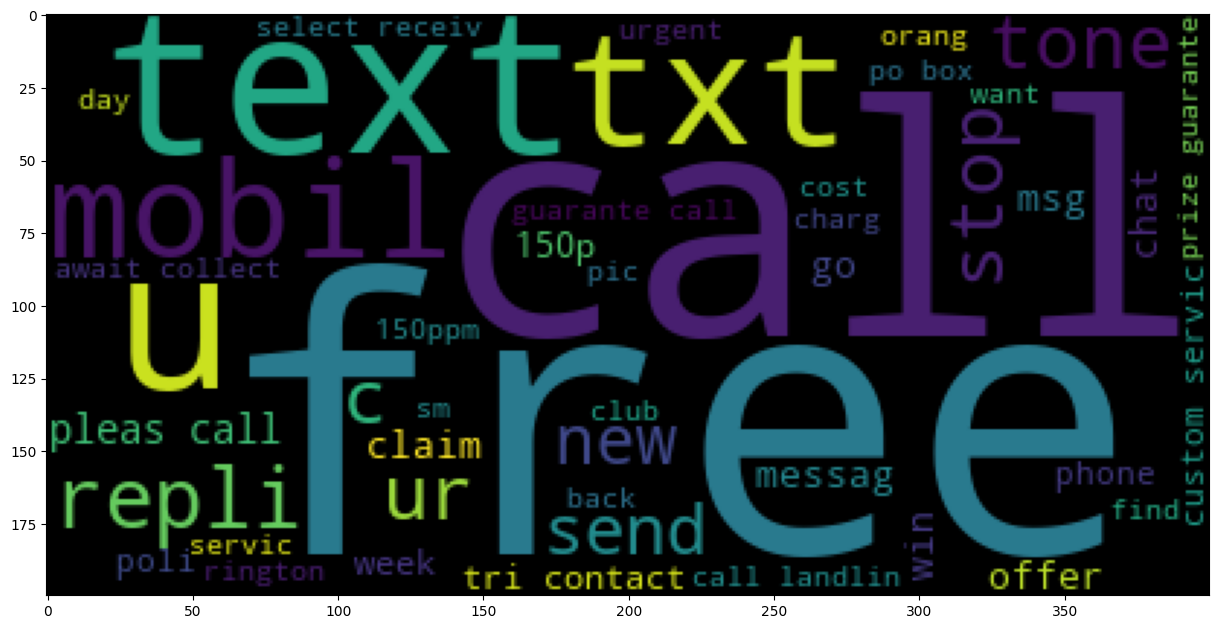

In [27]:
wc = WordCloud(min_font_size=8)
spam_wc = wc.generate(data[data['v1']==1]['after_transformation'].str.cat(sep=" "))
plt.figure(figsize=(15, 8))
plt.imshow(spam_wc)

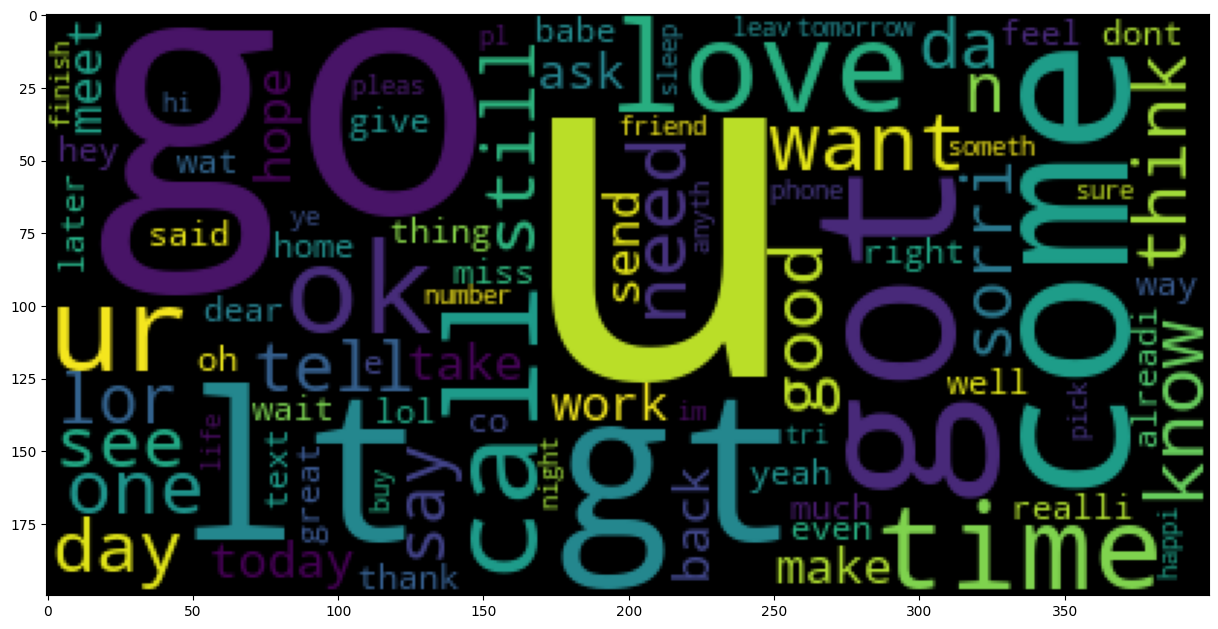

In [28]:
wc = WordCloud(min_font_size=8)
ham_wc = wc.generate(data[data['v1']==0]['after_transformation'].str.cat(sep=" "))
plt.figure(figsize=(15, 8))
plt.imshow(ham_wc)

MODEL BUILDING

In [29]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [30]:
X = tfidf.fit_transform(data['after_transformation']).toarray()

In [31]:
y = data['v1'].values

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [32]:
def acc_report(actual,predicted):
    acc_score=accuracy_score(actual,predicted)
    cm_matrix=confusion_matrix(actual,predicted)
    class_rep=classification_report(actual,predicted)
    print('the accuracy of tha model is ',acc_score)
    print(cm_matrix)
    print(class_rep)

In [33]:
mnb = MultinomialNB()
dtree = DecisionTreeClassifier(max_depth=5)
ada = AdaBoostClassifier(n_estimators=50, random_state=2)
rf = RandomForestClassifier(n_estimators=50, random_state=2)

In [36]:
mnb.fit(X_train, y_train)
dtree.fit(X_train, y_train)
ada.fit(X_train, y_train)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, random_state=2)

In [37]:
mnbtrain = mnb.predict(X_train)
mnbtest = mnb.predict(X_test)

dtreetrain = dtree.predict(X_train)
dtreetest = dtree.predict(X_test)

adatrain = ada.predict(X_train)
adatest = ada.predict(X_test)

rftrain = rf.predict(X_train)
rftest = rf.predict(X_test)

COMPARING ACCURACIES

In [38]:
print(acc_report(y_train, mnbtrain))
print(acc_report(y_test, mnbtest))

the accuracy of tha model is  0.9789600967351875
[[3618    2]
 [  85  430]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3620
           1       1.00      0.83      0.91       515

    accuracy                           0.98      4135
   macro avg       0.99      0.92      0.95      4135
weighted avg       0.98      0.98      0.98      4135

None
the accuracy of tha model is  0.9709864603481625
[[896   0]
 [ 30 108]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       896
           1       1.00      0.78      0.88       138

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034

None


In [39]:
print(acc_report(y_train, dtreetrain))
print(acc_report(y_test, dtreetest))

the accuracy of tha model is  0.9496977025392986
[[3585   35]
 [ 173  342]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3620
           1       0.91      0.66      0.77       515

    accuracy                           0.95      4135
   macro avg       0.93      0.83      0.87      4135
weighted avg       0.95      0.95      0.95      4135

None
the accuracy of tha model is  0.9274661508704062
[[877  19]
 [ 56  82]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       896
           1       0.81      0.59      0.69       138

    accuracy                           0.93      1034
   macro avg       0.88      0.79      0.82      1034
weighted avg       0.92      0.93      0.92      1034

None


In [40]:
print(acc_report(y_train, adatrain))
print(acc_report(y_test, adatest))

the accuracy of tha model is  0.9717049576783555
[[3603   17]
 [ 100  415]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3620
           1       0.96      0.81      0.88       515

    accuracy                           0.97      4135
   macro avg       0.97      0.90      0.93      4135
weighted avg       0.97      0.97      0.97      4135

None
the accuracy of tha model is  0.960348162475822
[[888   8]
 [ 33 105]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       896
           1       0.93      0.76      0.84       138

    accuracy                           0.96      1034
   macro avg       0.95      0.88      0.91      1034
weighted avg       0.96      0.96      0.96      1034

None


In [41]:
print(acc_report(y_train, rftrain))
print(acc_report(y_test, rftest))

the accuracy of tha model is  0.999758162031439
[[3620    0]
 [   1  514]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3620
           1       1.00      1.00      1.00       515

    accuracy                           1.00      4135
   macro avg       1.00      1.00      1.00      4135
weighted avg       1.00      1.00      1.00      4135

None
the accuracy of tha model is  0.9758220502901354
[[894   2]
 [ 23 115]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       896
           1       0.98      0.83      0.90       138

    accuracy                           0.98      1034
   macro avg       0.98      0.92      0.94      1034
weighted avg       0.98      0.98      0.97      1034

None


In [42]:
import pickle

# Save the TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Save the best model, let's say it's the MultinomialNB in this case
with open('spam_classifier_model.pkl', 'wb') as f:
    pickle.dump(mnb, f)

# Load the TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)

# Load the saved model
with open('spam_classifier_model.pkl', 'rb') as f:
    mnb = pickle.load(f)
